In [57]:
### **1. PVAD1_SC_Denoising model load
import yaml
from pathlib import Path

import torch
import torchaudio
from resemblyzer import VoiceEncoder, preprocess_wav
import numpy as np
from librosa.feature import melspectrogram
from common.model_loader import get_model, load_pretrained_model
from common.feature_extraction import LogMelFeatureExtractor


# path to folder with checkpoint.pth
CHECKPOINT_PATH = Path("pretrained_models/PVAD/PVAD1_SC_DenoisingAPC_finetune_100h_noisy_no_cafe_100744/best.pt").resolve()

# Features extractor
feature_config = {'sample_rate': 16000,
                  'n_mels': 40,
                  'n_fft': 400,
                  'window_length': 400,
                  'hop_length': 160}
feature_extractor = LogMelFeatureExtractor(**feature_config)

# test device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Get model config
yaml.add_multi_constructor('tag:yaml.org,2002:python/object/apply:torch.device',
                            lambda loader, suffix, node: None)
with open(str(CHECKPOINT_PATH.parent / "settings.txt"), "r", encoding="utf8") as file:
    config = yaml.load(file, Loader=yaml.FullLoader)
model_config = config["hparams"]["model"]["encoder"]

model = get_model(model_config)
model = load_pretrained_model(model, checkpoint_path=str(CHECKPOINT_PATH), map_location="cpu")

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

model = model.to(device)

Loaded checkpoint /Users/yasushi.sakita/dev/python/SSL-PVAD/pretrained_models/PVAD/PVAD1_SC_DenoisingAPC_finetune_100h_noisy_no_cafe_100744/best.pt.
Total number of parameters: 60,548


In [58]:
### **2. d-vector model load and define cos similarity function.. etc
speaker_encoder = VoiceEncoder(device="cpu") # d-vector output encoder

def cos_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def compute_similarity(waveform, speaker_embedding, speaker_encoder):
    rate = 2.5
    min_coverage = 0.5
    waveform_copy = waveform[0].numpy().copy()
    wav_slices, mel_slices = speaker_encoder.compute_partial_slices(waveform_copy.size,
                                                                    rate=rate,
                                                                    min_coverage=min_coverage)
    max_wave_length = wav_slices[-1].stop
    if max_wave_length >= waveform_copy.size:
        waveform_copy = np.pad(waveform_copy, (0, max_wave_length - waveform_copy.size), "constant")
    features = melspectrogram(y=waveform_copy, sr=16000, n_fft=400, hop_length=160, n_mels=40).astype('float32').T
    features_sliced = np.array([features[s] for s in mel_slices])
    with torch.no_grad():
        embedding_slices = speaker_encoder(torch.from_numpy(features_sliced)).numpy()

    scores_slices = np.array([cos_sim(speaker_embedding, partial_embedding) for partial_embedding in embedding_slices])

    # Scores, linearly interpolated, starting from 0.5 every time
    frame_step = int(np.round((16000 / rate) / 160))
    # First 160 frames are score one (160 frames window)
    scores_linear_interpolated = np.kron(scores_slices[0], np.ones(160, dtype='float32'))
    # The rest are linearly interpolated
    for i, s in enumerate(scores_slices[1:]):
        scores_linear_interpolated = np.append(scores_linear_interpolated,
                                               np.linspace(scores_slices[i], s, frame_step, endpoint=False))

    similarity = torch.from_numpy(scores_linear_interpolated)
    return similarity

def process_audio(audio_path, feature_extractor, compute_similarity, speaker_embedding, speaker_encoder):
    """
    Processes an audio file and computes feature representations and similarity vectors.

    Args:
        audio_path (str): Path to the audio file.
        feature_extractor (callable): Function for extracting features.
        compute_similarity (callable): Function for computing the similarity vector.
        speaker_embedding (torch.Tensor): Speaker embedding vector.
        speaker_encoder (callable): Speaker encoder function.

    Returns:
        tuple(torch.Tensor, torch.Tensor): (features, similarity)
            - features: Tensor of shape [1, 1085, 40], representing the extracted features.
            - similarity: Tensor of shape [1, 1085], representing the similarity vector.
    """
    # Load the audio file
    input_tensor, input_sample_rate = torchaudio.load(audio_path)

    # Resample if necessary
    if input_sample_rate != 16000:
        input_tensor = torchaudio.transforms.Resample(orig_freq=input_sample_rate, new_freq=16000)(input_tensor)

    # Compute feature representations
    features = feature_extractor(input_tensor.unsqueeze(0))
    lengths = torch.tensor([features.size(-1)])

    # Compute similarity vector
    similarity = compute_similarity(input_tensor, speaker_embedding, speaker_encoder)[:features.size(-1)]

    # Adjust tensor shapes
    features = features.squeeze(1)  # [1, 1, 40, 1085] → [1, 40, 1085]
    features = features.transpose(1, 2)  # [1, 40, 1085] → [1, 1085, 40]
    similarity = similarity.unsqueeze(0)  # [1085] → [1, 1085]

    return features, lengths, similarity


def infer_vad_model(model, features, lengths, similarity):
    """
    Runs the VAD model inference with the given input features and similarity scores.

    Args:
        model (torch.nn.Module): The VAD model to be used for inference.
        features (torch.Tensor): Extracted audio features for the target speech.
        lengths (torch.Tensor): Tensor containing the sequence lengths.
        similarity (torch.Tensor): Similarity scores.

    Returns:
        torch.Tensor: Model outputs.
    """
    with torch.no_grad():
        outputs = model(x=features, x_lens=lengths, similarity_scores=similarity)

    return outputs


Loaded the voice encoder model on cpu in 0.01 seconds.


In [59]:
### **3. reference audio load and fetch d-vector(embedding)
REFERENCE_WAV_PATH = "20250306170609.wav"

# Load audio file
waveform, sample_rate = torchaudio.load(REFERENCE_WAV_PATH)

# Resample if necessary
if sample_rate != 16000:
    waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)

# Convert to numpy array and preprocess for d-vector
waveform_preprocessed = preprocess_wav(waveform.numpy().squeeze())
speaker_embedding = torch.from_numpy(speaker_encoder.embed_speaker([waveform_preprocessed])).unsqueeze(0)

In [60]:
### **4. input audio load and calculate vector similarity.

no_target_speech_audio_path = "20250306174420.wav"

no_target_speech_audio_features, no_target_speech_audio_length, no_target_speech_audio_similarity = process_audio(
    no_target_speech_audio_path,
    feature_extractor,
    compute_similarity,
    speaker_embedding,
    speaker_encoder
)

target_speech_audio_path = "20250306170508.wav"

target_speech_audio_features, target_speech_audio_length ,target_speech_audio_similarity = process_audio(
    target_speech_audio_path,
    feature_extractor,
    compute_similarity,
    speaker_embedding,
    speaker_encoder
)


/var/folders/94/xd98kclj4y37fbg6sxv33h_40000gn/T/ipykernel_25728/2579691164.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


In [62]:
print("No Target Speech Features shape:", no_target_speech_audio_features.shape)
print("No Target Speech Audio length:", no_target_speech_audio_length)
print("No Target Speech Similarity shape:", no_target_speech_audio_similarity.shape)

print("Target Speech Features shape:", target_speech_audio_features.shape)
print("Target Speech Audio length:", target_speech_audio_length)
print("Target Speech Similarity shape:", target_speech_audio_similarity.shape)

No Target Speech Features shape: torch.Size([1, 1191, 40])
No Target Speech Audio length: tensor([1191])
No Target Speech Similarity shape: torch.Size([1, 1191])
Target Speech Features shape: torch.Size([1, 1085, 40])
Target Speech Audio length: tensor([1085])
Target Speech Similarity shape: torch.Size([1, 1085])


In [63]:
no_target_speech_outputs = infer_vad_model(model, no_target_speech_audio_features, no_target_speech_audio_length, no_target_speech_audio_similarity)
target_speech_outputs = infer_vad_model(model, target_speech_audio_features, target_speech_audio_length, target_speech_audio_similarity)

In [64]:
no_target_speech_vad_scores = torch.nn.functional.softmax(no_target_speech_outputs[0], dim=-1)
target_speech_vad_scores = torch.nn.functional.softmax(target_speech_outputs[0], dim=-1)

In [70]:
import matplotlib.pyplot as plt

def plot_vad_scores(vad_scores, title):
    """
    Plots the VAD scores for no-speech, target-speech, and non-target-speech categories.

    Args:
        vad_scores (torch.Tensor): VAD score tensor of shape [batch, time_steps, 3].
    """
    plt.figure(figsize=(10, 4))  # Set figure size
    plt.plot(vad_scores[0, :, 0], label="no-speech")
    plt.plot(vad_scores[0, :, 1], label="target-speech")
    plt.plot(vad_scores[0, :, 2], label="non-target-speech")

    plt.legend()
    plt.xlabel("Time Steps")
    plt.ylabel("Probability")
    plt.title(title)
    plt.show()


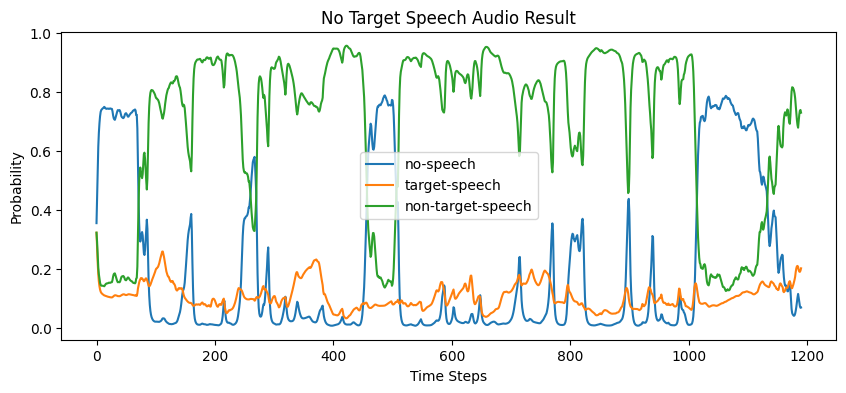

In [73]:
plot_vad_scores(no_target_speech_vad_scores, "No Target Speech Audio Result")

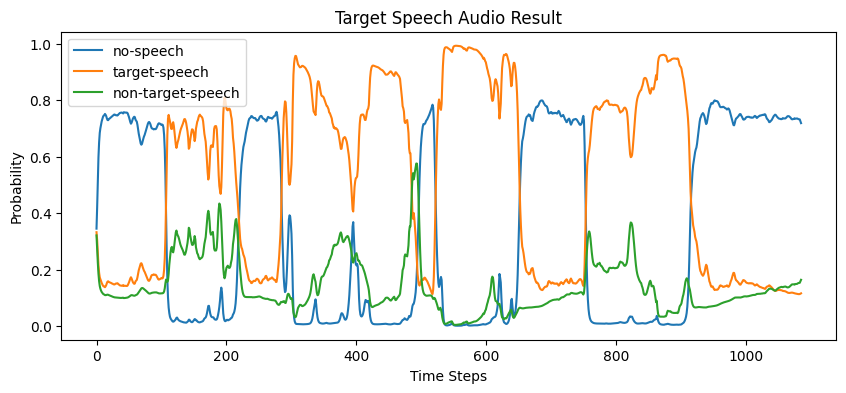

In [74]:
plot_vad_scores(target_speech_vad_scores, "Target Speech Audio Result")